# Imports

In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.preprocessing import StandardScaler

from reader.reader import read_csv
from mcda.uta import Criterion
from mcda.report import calculate_heuristics
from methods.autoencoder import AutoencoderModel

# S2

# Constants

In [2]:
available_points = [2, 3, 4]
n_components = [2, 3, 4]

# Read Data

In [3]:
df, CRITERIA = read_csv("data/s2.csv")
print(CRITERIA)
df.head()

[Criterion(name='g1', type=True, points=2), Criterion(name='g2', type=True, points=2), Criterion(name='g3', type=True, points=2), Criterion(name='g4', type=True, points=2), Criterion(name='g5', type=True, points=2)]


,g1,g2,g3,g4,g5
a01,-18342.0,-30.7,-37.2,2.33,3.00
a02,-15335.0,-30.2,-41.6,2.00,2.50
a03,-16973.0,-29.0,-34.9,2.66,2.50
a04,-15460.0,-30.4,-35.8,1.66,1.50
a05,-15131.0,-29.7,-35.6,1.66,1.75


# Scaling data

In [4]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled.head()

,g1,g2,g3,g4,g5
0,-0.570300,-1.340119,-0.506700,0.844652,1.364564
1,0.970682,-0.742614,-3.065118,-0.054494,0.476011
2,0.131264,0.691399,0.830655,1.743798,0.476011
3,0.906624,-0.981616,0.307342,-0.980886,-1.301096
4,1.075225,-0.145108,0.423634,-0.980886,-0.856819


# Preferences

In [46]:
from typing import List


def is_dominating(a_values: List[float], b_values: List[float]) -> bool:
    """
    Check if a is dominating b
    Parameters
    ----------
    a_values (List[float, ...]): List of performances for a
    b_values (List[float, ...]): List of performances for b

    Returns
    -------
    bool: True if a is dominating b, False otherwise

    """
    return all(a >= b for a, b in zip(a_values, b_values)) and any(
        a > b for a, b in zip(a_values, b_values)
    )

# stores information if for a given method and number of components (n)
# alternative 1 dominates alternative 2
# domination[(method, n)][alt_2, alt_1]
domination = defaultdict(dict)

for n in n_components:
    methods = {
        "PCA": PCA(n_components=n, random_state=42),
        # "Autoencoder": AutoencoderModel(encoded_dim=n, epochs=300, batch_size=16),
        "KernelPCA": KernelPCA(n_components=n, random_state=42),
        "t-SNE": TSNE(n_components=n, perplexity=10, method="exact", random_state=42),
        "MDS": MDS(n_components=n, random_state=42),
        "Isomap": Isomap(n_components=n),
    }
    for method_name, method in methods.items():
        df_m = (
            pd.DataFrame(method.fit_transform(df_scaled), index=df.index, columns=range(n))
            .map(lambda x: f"{x:.4f}")
            .astype(np.float64)
        )

        for alt_1 in df_m.index:
            for alt_2 in df_m.index:
                if alt_1 == alt_2:
                    continue
                domination[(method_name, n)][(alt_2, alt_1)] = is_dominating(
                    df_m.loc[alt_1, :].tolist(), df_m.loc[alt_2, :].tolist()
                )
        
df_domination = pd.DataFrame(domination)
df_domination_f = df_domination[df_domination.eq(False).all(axis=1)]

[(i, x) for i, x in enumerate(df_domination_f.index)]

[(0, ('a02', 'a01')),
 (1, ('a10', 'a01')),
 (2, ('a01', 'a03')),
 (3, ('a02', 'a03')),
 (4, ('a10', 'a03')),
 (5, ('a12', 'a03')),
 (6, ('a01', 'a04')),
 (7, ('a02', 'a04')),
 (8, ('a03', 'a04')),
 (9, ('a05', 'a04')),
 (10, ('a07', 'a04')),
 (11, ('a10', 'a04')),
 (12, ('a11', 'a04')),
 (13, ('a12', 'a04')),
 (14, ('a01', 'a05')),
 (15, ('a02', 'a05')),
 (16, ('a10', 'a05')),
 (17, ('a11', 'a05')),
 (18, ('a03', 'a06')),
 (19, ('a12', 'a06')),
 (20, ('a01', 'a07')),
 (21, ('a02', 'a07')),
 (22, ('a06', 'a07')),
 (23, ('a10', 'a07')),
 (24, ('a11', 'a07')),
 (25, ('a14', 'a07')),
 (26, ('a03', 'a08')),
 (27, ('a07', 'a08')),
 (28, ('a10', 'a08')),
 (29, ('a11', 'a08')),
 (30, ('a12', 'a08')),
 (31, ('a02', 'a09')),
 (32, ('a04', 'a09')),
 (33, ('a07', 'a09')),
 (34, ('a08', 'a09')),
 (35, ('a10', 'a09')),
 (36, ('a11', 'a09')),
 (37, ('a13', 'a09')),
 (38, ('a14', 'a09')),
 (39, ('a01', 'a12')),
 (40, ('a02', 'a12')),
 (41, ('a01', 'a13')),
 (42, ('a04', 'a13')),
 (43, ('a07', 'a13'))

In [47]:
PREFERENCES = [
    df_domination_f.index[1],
    df_domination_f.index[10]
]
PREFERENCES

[('a10', 'a01'), ('a07', 'a04')]

# Calculations

In [48]:
results_original = defaultdict(dict)
for points in available_points:
    print(f"points: {points}, method: original")
    criteria = [Criterion(name, points=points) for name in df.columns]
    f_nec, f_era, f_pwi, f_rai = calculate_heuristics(df, PREFERENCES, criteria)
    results_original["original"][(f"points: {points}", "f_nec")] = f_nec
    results_original["original"][(f"points: {points}", "f_era")] = f_era
    results_original["original"][(f"points: {points}", "f_pwi")] = f_pwi
    results_original["original"][(f"points: {points}", "f_rai")] = f_rai

points: 2, method: original
points: 3, method: original
points: 4, method: original


In [49]:
df_results_original = pd.DataFrame(results_original)
df_results_original

original
points: 2 f_nec  16.000000
          f_era   9.071429
          f_pwi   0.223076
          f_rai   2.680671
points: 3 f_nec   9.000000
          f_era  11.071429
          f_pwi   0.214758
          f_rai   2.649414
points: 4 f_nec   9.000000
          f_era  11.500000
          f_pwi   0.202429
          f_rai   2.595357

# Parallel

In [50]:
from concurrent.futures import ProcessPoolExecutor, as_completed


def process_point_method(points, n, method_name, method, df_scaled, df, PREFERENCES):
    df_m = (
        pd.DataFrame(method.fit_transform(df_scaled), index=df.index, columns=range(n))
        .map(lambda x: f"{x:.4f}")
        .astype(np.float64)
    )
    criteria = [Criterion(name, points=points) for name in df_m.columns]
    f_nec, f_era, f_pwi, f_rai = calculate_heuristics(df_m, PREFERENCES, criteria)

    return (
        method_name,
        n,
        points,
        {"f_nec": f_nec, "f_era": f_era, "f_pwi": f_pwi, "f_rai": f_rai},
    )


results = defaultdict(dict)


# Define the parallel execution using ProcessPoolExecutor
def run_parallel():
    with ProcessPoolExecutor() as executor:
        future_to_task = {
            executor.submit(
                process_point_method,
                points,
                n,
                method_name,
                method,
                df_scaled,
                df,
                PREFERENCES,
            ): (points, n, method_name)
            for points in available_points
            for n in n_components
            for method_name, method in {
                "PCA": PCA(n_components=n, random_state=42),
                # "Autoencoder": AutoencoderModel(encoded_dim=n, epochs=300, batch_size=16),
                "KernelPCA": KernelPCA(n_components=n, random_state=42),
                "t-SNE": TSNE(n_components=n, perplexity=10, method="exact", random_state=42),
                "MDS": MDS(n_components=n, random_state=42),
                "Isomap": Isomap(n_components=n),
            }.items()
        }

        for future in as_completed(future_to_task):
            method_name, n, points, metrics = future.result()
            results[(method_name, f"dims: {n}")][(f"points: {points}", "f_nec")] = metrics["f_nec"]
            results[(method_name, f"dims: {n}")][(f"points: {points}", "f_era")] = metrics["f_era"]
            results[(method_name, f"dims: {n}")][(f"points: {points}", "f_pwi")] = metrics["f_pwi"]
            results[(method_name, f"dims: {n}")][(f"points: {points}", "f_rai")] = metrics["f_rai"]


run_parallel()

Infeasible system.



In [61]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_index(axis=1, level=[0, 1])
df_results

Isomap                        KernelPCA             \
                   dims: 2    dims: 3    dims: 4    dims: 2    dims: 3   
points: 2 f_nec  85.000000  85.000000  85.000000  90.000000  66.000000   
          f_era   0.857143   0.857143   0.857143   0.142857   2.928571   
          f_pwi   0.022296   0.017276   0.009464   0.001799   0.066550   
          f_rai   0.536993   0.412736   0.225429   0.046771   1.139871   
points: 3 f_nec  66.000000  42.000000  28.000000  89.000000  36.000000   
          f_era   4.142857   6.785714   8.214286   0.285714   7.000000   
          f_pwi   0.067086   0.118144   0.108727   0.003378   0.195525   
          f_rai   1.286229   1.754629   1.677364   0.087829   2.054329   
points: 4 f_nec  58.000000  35.000000  25.000000  83.000000  34.000000   
          f_era   4.642857   7.285714   8.500000   1.357143   8.000000   
          f_pwi   0.068431   0.096907   0.095619   0.020597   0.187963   
          f_rai   1.333807   1.582443   1.608329   0.486007   2.086886   

                                  MDS                              PCA  \
                   dims: 4    dims: 2    dims: 3    dims: 4    dims: 2   
points: 2 f_nec  66.000000  87.000000  32.000000  35.000000  43.000000   
          f_era   3.000000   0.500000   7.428571   6.928571   5.428571   
          f_pwi   0.057476   0.015946   0.212153   0.140360   0.190114   
          f_rai   1.119600   0.389300   2.513793   1.898886   2.017264   
points: 3 f_nec  31.000000  87.000000  26.000000  23.000000  43.000000   
          f_era   7.571429   0.500000   9.071429   9.428571   6.500000   
          f_pwi   0.177971   0.015883   0.206018   0.208166   0.164551   
          f_rai   1.908057   0.383664   2.577979   2.447014   1.991557   
points: 4 f_nec  23.000000  81.000000  26.000000  22.000000  43.000000   
          f_era   9.142857   1.571429   9.500000  10.285714   7.357143   
          f_pwi   0.155132   0.033604   0.197731   0.171242   0.155231   
          f_rai   1.816229   0.692957   2.567693   2.278907   1.981593   

                                            t-SNE                        
                   dims: 3    dims: 4     dims: 2    dims: 3    dims: 4  
points: 2 f_nec  30.000000  22.000000  182.000000  39.000000  18.000000  
          f_era   7.214286   8.642857   13.000000   6.642857   8.857143  
          f_pwi   0.210262   0.246707         NaN   0.173556   0.205336  
          f_rai   2.504886   2.771893         NaN   2.264279   2.369414  
points: 3 f_nec  28.000000  21.000000   64.000000  31.000000  10.000000  
          f_era   8.357143   9.857143    3.928571   8.785714  11.071429  
          f_pwi   0.203937   0.230338    0.072237   0.182436   0.218113  
          f_rai   2.555821   2.760379    1.384629   2.428800   2.537121  
points: 4 f_nec  28.000000  21.000000   54.000000  30.000000   9.000000  
          f_era   9.428571  10.785714    5.571429   9.142857  11.785714  
          f_pwi   0.194034   0.219418    0.091653   0.173349   0.213045  
          f_rai   2.529993   2.716186    1.642493   2.385579   2.581986

In [62]:
df_results.columns = pd.MultiIndex.from_tuples(
    [(method, int(dim.split(": ")[1])) for method, dim in df_results.columns],
    names=["method", "dim"],
)
df_results.index = pd.MultiIndex.from_tuples([(heu, int(p.split(": ")[1])) for p, heu in df_results.index])

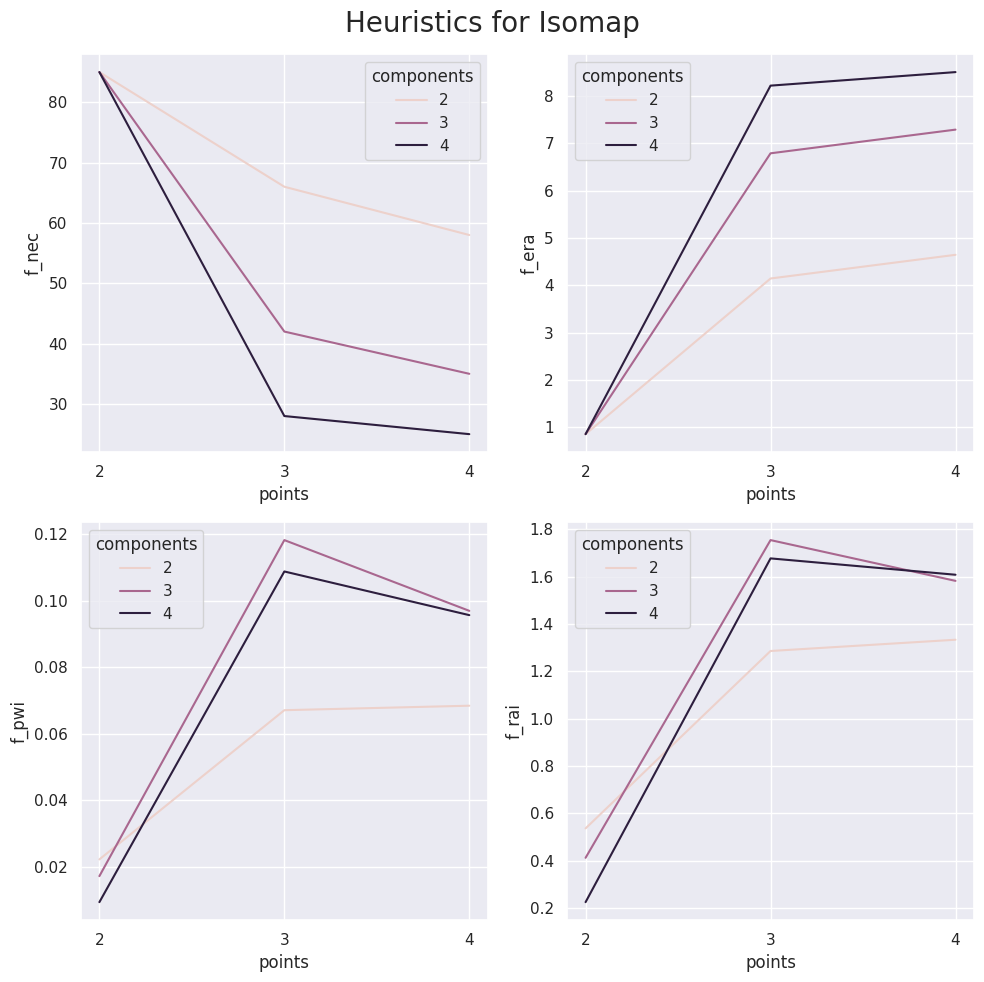

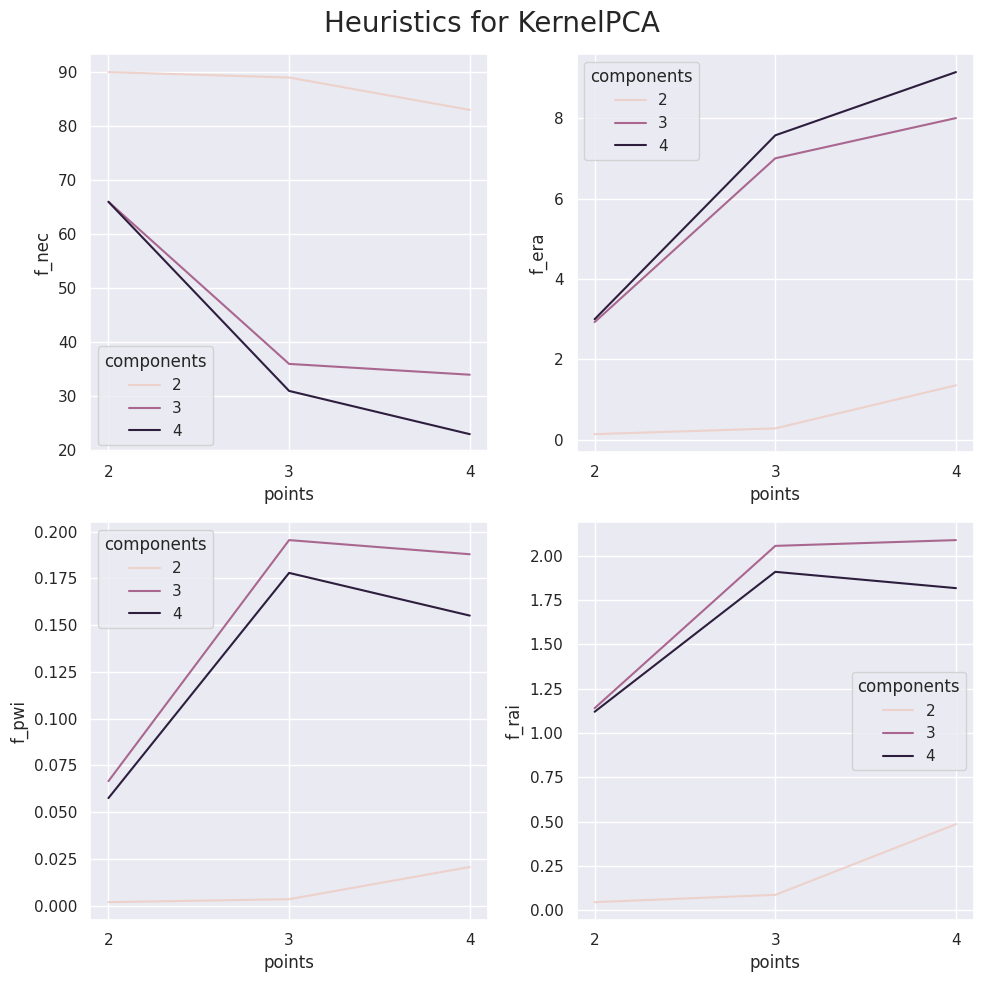

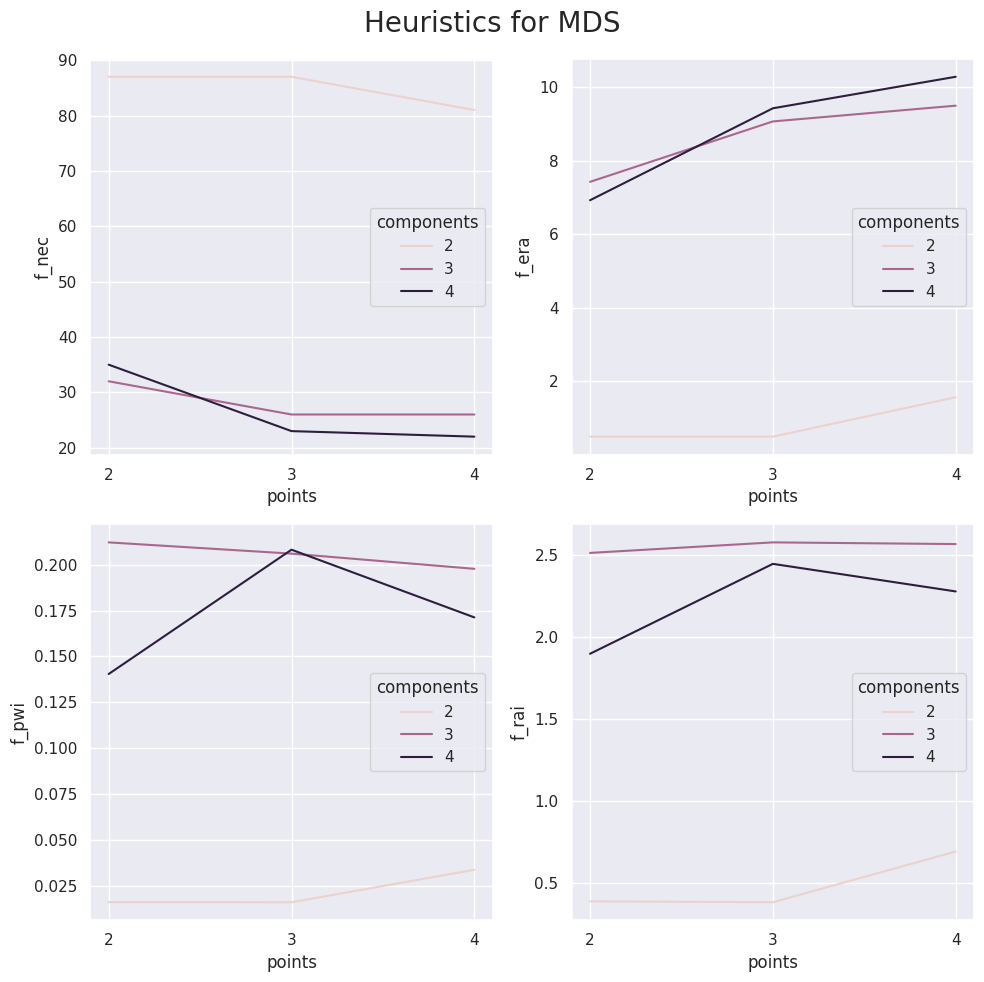

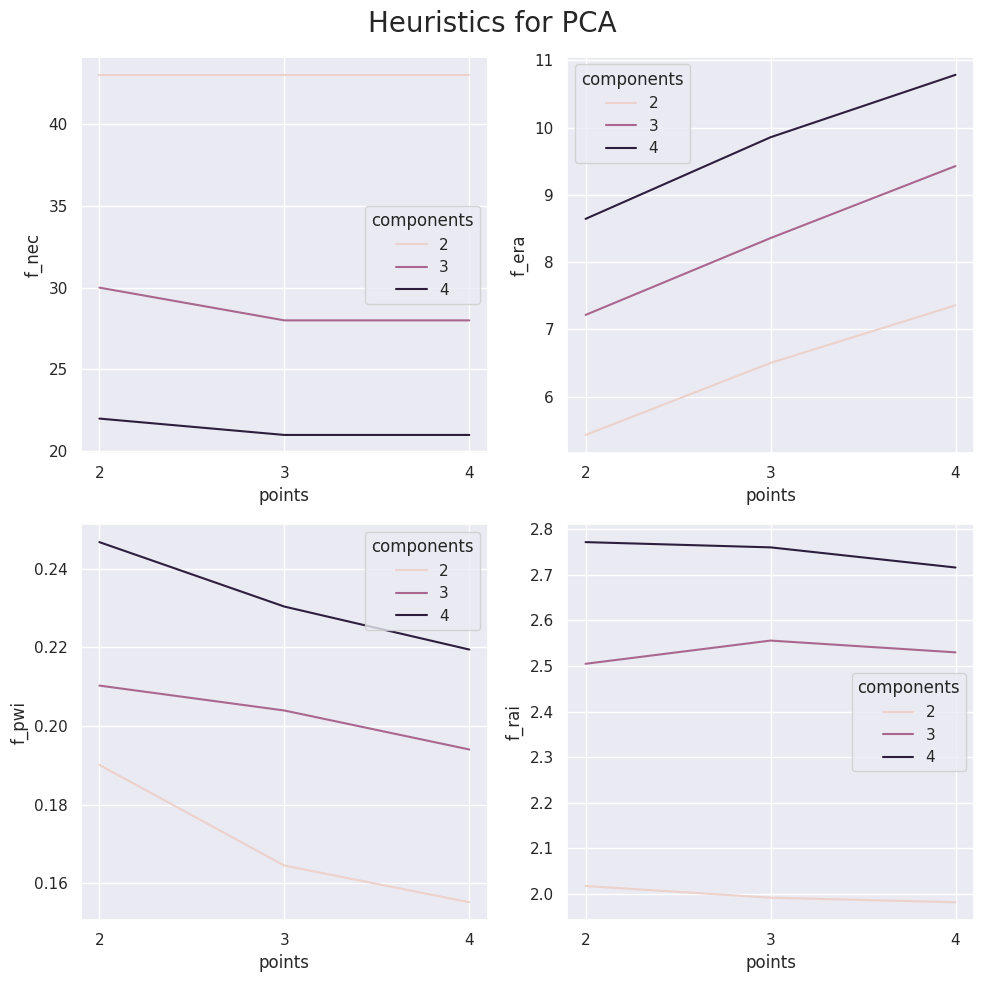

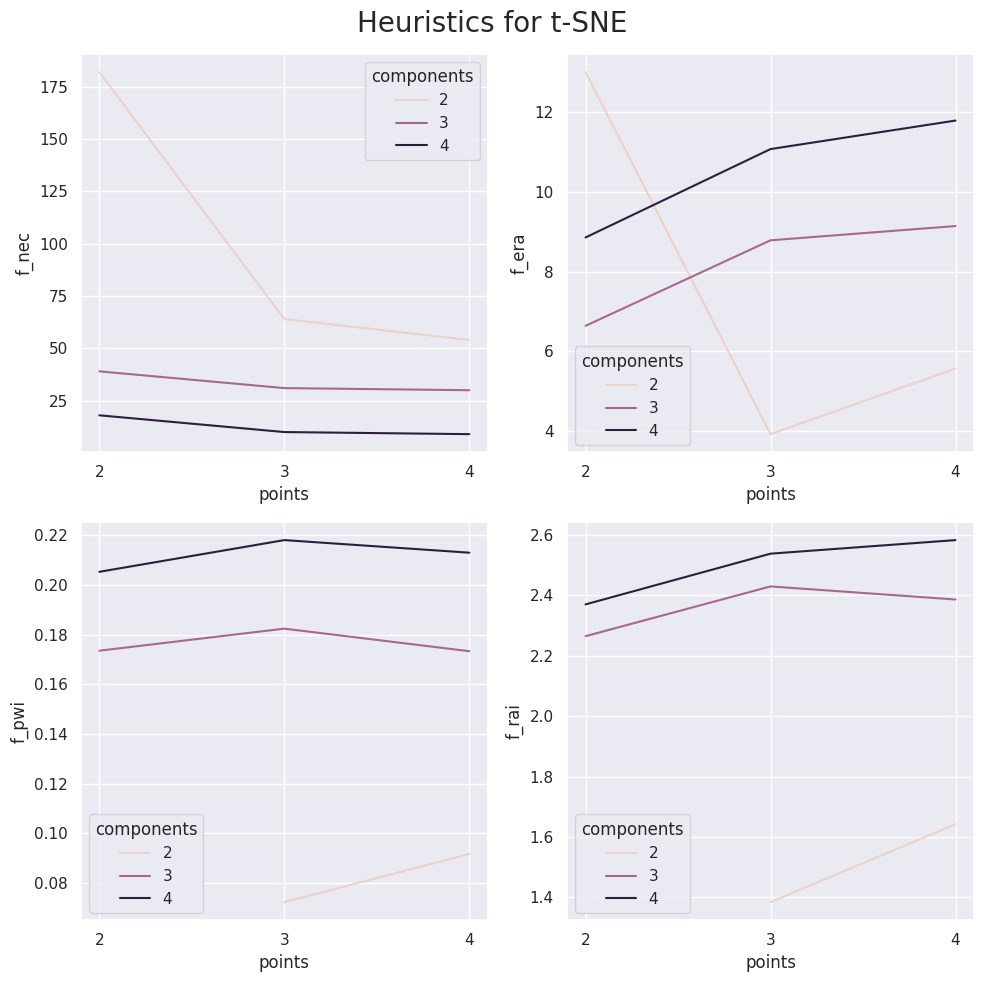

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

unique_n_points = df_results.index.get_level_values(0).unique()
heuristics = df_results.index.get_level_values(0).unique()

methods = df_results.columns.get_level_values(0).unique()

for method in methods:
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()

    for i, heuristic in enumerate(heuristics):
        df_r = df_results[method].loc[heuristic].reset_index(names="points").melt(id_vars=['points'], var_name="components", value_name="value")
        sns.lineplot(x="points", y="value", hue="components", data=df_r, ax=axes[i])
        axes[i].set_xticks(df_r["points"].unique())
        axes[i].set_ylabel(heuristic)
    
    plt.suptitle(f"Heuristics for {method}", fontsize=20)
    plt.tight_layout()
    plt.show()